# 1.0 CitiBike Viz

* add elevation https://developers.google.com/maps/documentation/elevation/start
* visualize using ipyleaflet
* time vs station depart/arrive
* age vs station depart/arrive
* ave vs time depart/arrive
* station-station distances and google maps biking distances
* add neighborhood categories to stations

In [1]:
from clustergrammer2 import net
df = {}

In [144]:
import himc_helper_functions_v0_12_3 as hf
import datetime
import umap

In [146]:
def make_umap_plot(df, cat_index, colors_dict, title, min_dist=1.0, n_neighbors=20, s=5.0, alpha=1.0, 
                   figsize=(10,10)):
    cols = df.columns.tolist()
    cats = [x[cat_index] for x in cols]
    list_colors = [colors_dict[x.split(': ')[1]] for x in cats]
    
    
    
    embedding = umap.UMAP(n_neighbors=n_neighbors, random_state=99,
                          min_dist=min_dist,
                          metric='correlation').fit_transform(df.transpose())
    
    df_umap = pd.DataFrame(data=embedding, columns=['x', 'y'])
    df_umap.plot(kind='scatter', x='x', y='y',  c=list_colors, alpha=alpha, s=s, figsize=figsize, 
                 title=title)
    
    return df_umap

In [2]:
import pandas as pd
from copy import deepcopy
import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline 

In [18]:
df_ini = pd.read_csv('../data/big_data/201901-citibike-tripdata.csv')
df_ini.shape

(967287, 15)

In [119]:
now = datetime.datetime.now()
inst_year = now.year
inst_year

2020

In [135]:
mean_age = 40

In [19]:
df_ini.columns.tolist()

['tripduration',
 'starttime',
 'stoptime',
 'start station id',
 'start station name',
 'start station latitude',
 'start station longitude',
 'end station id',
 'end station name',
 'end station latitude',
 'end station longitude',
 'bikeid',
 'usertype',
 'birth year',
 'gender']

In [44]:
for inst_station in all_stations:
    if '&' not in inst_station:
        print(inst_station)

10 Hudson Yards
58th St Depot
Cherry St
Great Jones St
NYCBS DEPOT - DELANCEY
NYCBS Depot - GOW
Old Fulton St
Pershing Square North
Pershing Square South
Pier 40 - Hudson River Park
Washington Park
Water - Whitehall Plaza
West Thames St


### Station Metadata

In [106]:
df_meta = pd.DataFrame(all_stations, index=all_stations, columns=['station crossing'])
for inst_point in ['start', 'end']:
    
    # x 
    df_meta['cross-y'] = df_meta['station crossing'].apply(lambda x: str(x).split(' & ')[0] if '&' in str(x) else x)
    
    # y 
    df_meta['cross-x'] = df_meta['station crossing'].apply(lambda x: str(x).split(' & ')[1] if '&' in str(x) else x)
    
    # Street
    ser_st = pd.Series(index=df_meta['cross-y'].index.tolist())
    ser_ave = pd.Series(index=df_meta['cross-y'].index.tolist())
    
    # Find Street and Avenue
    for inst_row in ser_st.index.tolist():
        inst_st = 'N.A.'
        inst_ave = 'N.A.'
        
        # Find street
        if ' St' in df_meta.loc[inst_row, 'cross-y']:
            inst_st = df_meta.loc[inst_row, 'cross-y']
        elif ' St' in df_meta.loc[inst_row, 'cross-x']:
            inst_st = df_meta.loc[inst_row, 'cross-x']
            
        # Find Avenue
        if ' Ave' in df_meta.loc[inst_row, 'cross-y']:
            inst_ave = df_meta.loc[inst_row, 'cross-y']
        elif ' Ave' in df_meta.loc[inst_row, 'cross-x']:
            inst_ave = df_meta.loc[inst_row, 'cross-x']
        
        ser_st[inst_row] = inst_st
        ser_ave[inst_row] = inst_ave

df_meta['St'] = ser_st
df_meta['Ave'] = ser_ave

### Calc Destination Distributions
Save positions of stations

In [136]:
all_stations = sorted(df_ini['start station name'].value_counts().index.tolist())
len(all_stations)

df_dest = pd.DataFrame(0, index=all_stations, columns=all_stations)
for inst_station in all_stations:
    inst_df = df_ini.loc[df_ini['start station name'] == inst_station]
    ser_destination = inst_df['end station name'].value_counts()
    ser_destination.name = inst_station
    
    df_dest[inst_station] = ser_destination
    
    df_meta.loc[inst_station, 'start station latitude'] = inst_df['start station latitude'].mean()
    df_meta.loc[inst_station, 'start station longitude'] = inst_df['start station longitude'].mean()    
    
    # save average departing age
    df_meta.loc[inst_station, 'departing age'] = inst_year - inst_df['birth year'].mean() - mean_age
    
    inst_df = df_ini.loc[df_ini['end station name'] == inst_station]    
    df_meta.loc[inst_station, 'arriving age'] = inst_year - inst_df['birth year'].mean() - mean_age   
    
df_dest.shape

(767, 767)

In [137]:
df_dest = df_dest.fillna(0)
df_dest.shape

(767, 767)

In [138]:
df_meta.head()

,station crossing,cross-y,cross-x,St,Ave,start station latitude,start station longitude,departing age,arriving age
1 Ave & E 110 St,1 Ave & E 110 St,1 Ave,E 110 St,E 110 St,1 Ave,40.792327,-73.938300,-1.676546,-1.569250
1 Ave & E 16 St,1 Ave & E 16 St,1 Ave,E 16 St,E 16 St,1 Ave,40.732219,-73.981656,-1.326959,0.605360
1 Ave & E 18 St,1 Ave & E 18 St,1 Ave,E 18 St,E 18 St,1 Ave,40.733812,-73.980544,0.437596,-0.225231
1 Ave & E 30 St,1 Ave & E 30 St,1 Ave,E 30 St,E 30 St,1 Ave,40.741444,-73.975361,0.644453,1.558185
1 Ave & E 44 St,1 Ave & E 44 St,1 Ave,E 44 St,E 44 St,1 Ave,40.750020,-73.969053,5.240284,4.919736


In [139]:
df_cat = deepcopy(df_dest)
add_cat_list = ['cross-x', 'cross-y', 'departing age']
new_cols = hf.add_cats_from_meta(add_cat_list=add_cat_list, barcodes=df_cat.columns.tolist(), df_meta=df_meta)

add_cat_list = ['cross-x', 'cross-y', 'arriving age']
new_rows = hf.add_cats_from_meta(add_cat_list=add_cat_list, barcodes=df_cat.index.tolist(), df_meta=df_meta)

df_cat.columns = new_cols
df_cat.index = new_rows

In [140]:
df_norm = net.umi_norm(df_cat)

In [141]:
net.load_df(df_norm)
net.normalize(axis='row', norm_type='zscore')
net.clip(-5,5)
net.widget()

ExampleWidget(network='{"row_nodes": [{"name": "1 Ave & E 110 St", "ini": 767, "clust": 404, "rank": 98, "rank…

In [162]:
df_export = net.export_df()
df_export.to_csv('../data/processed/citibike.csv')

In [143]:
!mkdir -p ../data/processed/
net.save_dict_to_json(inst_dict=net.viz, filename='../data/processed/pre-calc-viz.json', indent=False)

### Calculate UMAP

In [148]:
ini_cat_colors = net.viz['cat_colors']['col']['cat-0']
cat_colors = {}
for inst_key in ini_cat_colors:
    cat_colors[inst_key.split(': ')[1]] = ini_cat_colors[inst_key]

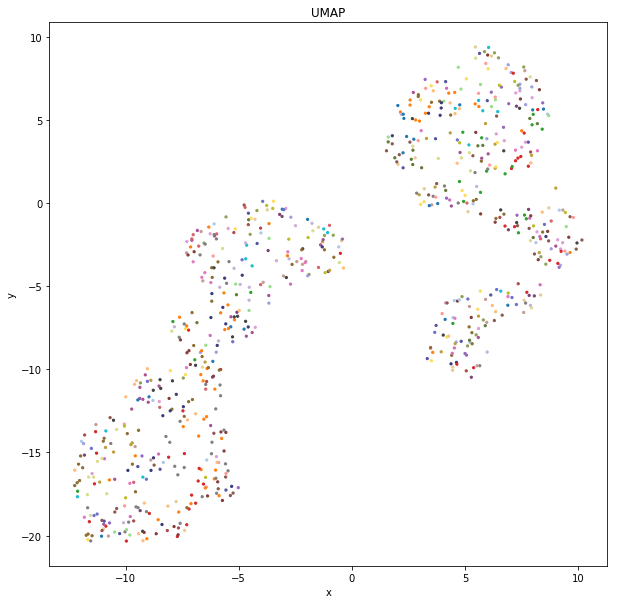

In [149]:
df_umap = make_umap_plot(df_norm, cat_index=1, title='UMAP', colors_dict=cat_colors)

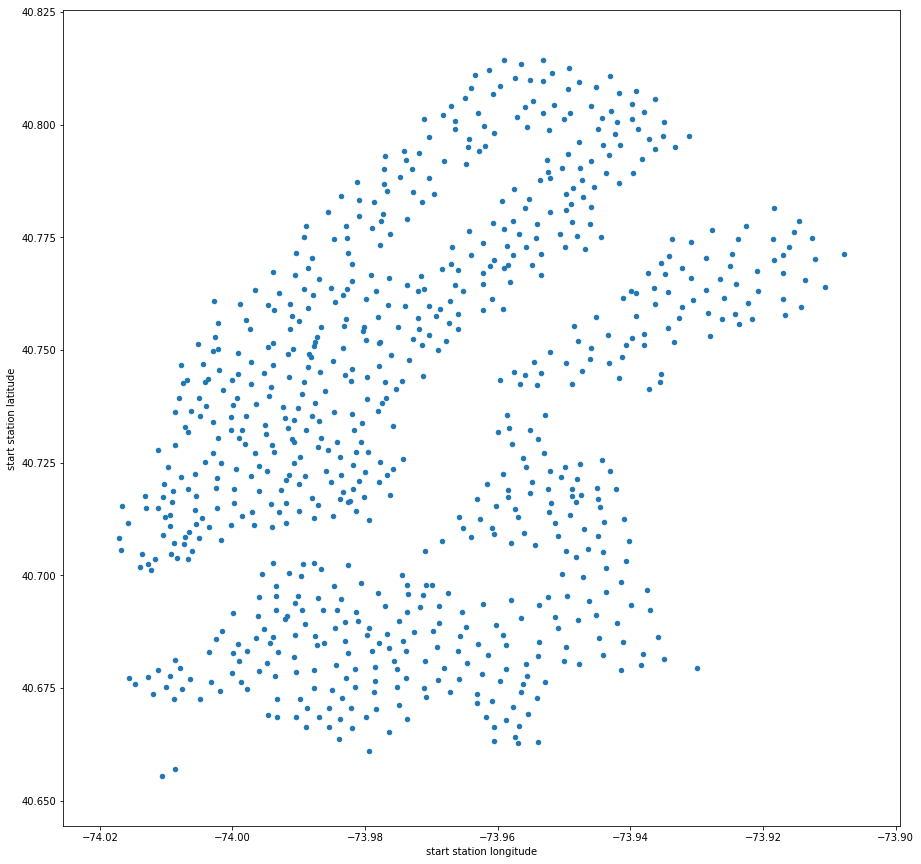

In [154]:
df_meta.plot(kind='scatter', x='start station longitude', y='start station latitude', figsize=(15,15))

In [157]:
df_umap.columns = ['umap-x', 'umap-y']
df_umap.index = df_meta.index.tolist()

In [158]:
df_new_meta = pd.concat([df_meta, df_umap], axis=1)

In [159]:
df_new_meta.head()

,station crossing,cross-y,cross-x,St,Ave,start station latitude,start station longitude,departing age,arriving age,umap-x,umap-y
1 Ave & E 110 St,1 Ave & E 110 St,1 Ave,E 110 St,E 110 St,1 Ave,40.792327,-73.938300,-1.676546,-1.569250,-8.155725,-19.692968
1 Ave & E 16 St,1 Ave & E 16 St,1 Ave,E 16 St,E 16 St,1 Ave,40.732219,-73.981656,-1.326959,0.605360,-7.907963,-7.130380
1 Ave & E 18 St,1 Ave & E 18 St,1 Ave,E 18 St,E 18 St,1 Ave,40.733812,-73.980544,0.437596,-0.225231,-7.955847,-7.705673
1 Ave & E 30 St,1 Ave & E 30 St,1 Ave,E 30 St,E 30 St,1 Ave,40.741444,-73.975361,0.644453,1.558185,-6.487140,-9.565009
1 Ave & E 44 St,1 Ave & E 44 St,1 Ave,E 44 St,E 44 St,1 Ave,40.750020,-73.969053,5.240284,4.919736,-6.238329,-13.382294


In [161]:
df_new_meta.to_csv('../data/processed/df_meta_v2.csv')